## DEF OF CLASSES "ROUTE" AND "AIRPORT"

In [1]:
class Airport:
    name = ""
    city = ""
    country = ""
    iata = ""
    icao = ""
    lat = 0.
    long = 0.
    def info(self):
        return f'{self.iata}, {self.icao}\n{self.city}, {self.country}\nlat={self.lat}, long={self.long}'

class Route:
    source_iata = ""
    source_icao = ""
    dest_iata = ""
    dest_icao = ""
    dest_city = ""
    source_city = ""
    dest_country = ""
    source_country = ""
    flux = 0 # passenger per year (2017)
    def info(self):
        return f'source: {self.source_city}, {self.source_country}\ndest: {self.dest_city}, {self.dest_country}\nflux: {self.flux}'
    
    # Nota : il flusso verrà preso da un file che contiene solo rotte
    # per numero di passeggeri maggiore di 50000 all'anno
    
    #aggiungo questa proprietà così che quando confronto due oggetti
    #di questa classe, controlla il contenuto degli oggetti, e non
    #l'hash. Serve per eliminare i duplicati.
    def __eq__(self, other) : 
        return self.__dict__ == other.__dict__

## CREATING AIRPORTS DATABASE

In [2]:
import csv

airports = []
airport_file_path = 'airports.csv'
with open(airport_file_path) as file:
    reader = csv.reader(file, delimiter=',') 
    for line in reader:
        airport = Airport()
        airport.name = line[1]
        airport.city = line[2]
        airport.country = line[3]
        airport.iata = line[4]
        airport.icao = line[5]
        airport.lat = float(line[6])
        airport.long = float(line[7])
        airports.append(airport)
        
# # to save database:
# import pickle 
# with open("db_airports.dat", 'wb') as f:
#     pickle.dump(airports, f)

## CREATING ROUTES DATABASE:
"routes" è una lista di oggetti. Ogni oggetto appartiene alla classe "Route" e rappresenta una tratta aerea. Ogni oggetti ha i seguenti attributi:
- **source_iata** 
- **source_icao**
- **dest_iata**
- **dest_icao**
- **dest_country**
- **source_country**
- **source_city**
- **dest_city**
- **flux**

In [3]:
import csv
    
routes = []
routes_file_path = 'routes.csv'
with open(routes_file_path) as file:
    reader = csv.reader(file, delimiter=',') 
    for line in reader:
        route = Route()
        if len(line[2])==3:                                  # trovo iata nella partenza
            route.source_iata = line[2]
            for airport in airports:
                if airport.iata == route.source_iata:
                    route.source_country = airport.country
                    route.source_city = airport.city
                    break
        elif len(line[2])==4:                                # trovo icao nella partenza
            route.source_icao = line[2]
            for airport in airports:
                if airport.icao == route.source_icao:
                    route.source_country = airport.country
                    route.source_city = airport.city
                    break
        else: print("problem", line)
        if len(line[4])==3:                                  # trovo iata nell'arrivo
            route.dest_iata = line[4]
            for airport in airports:
                if airport.iata == route.dest_iata:
                    route.dest_country = airport.country
                    route.dest_city = airport.city
                    break
        elif len(line[4])==4:                                # trovo icao nell'arrivo
            route.dest_icao = line[4]
            for airport in airports:
                if airport.icao == route.dest_icao:
                    route.dest_country = airport.country
                    route.dest_city = airport.city
                    break
        else: print("problem", line)                         # non trovo un cazzo
        #qui aggiungo la route alla lista solo se non è già presente.
        #se già è presente, allora aumento il contatore "same_found"
        #di quella route già inserita.
        if not route in routes:
            routes.append(route)
        else:
            indice = routes.index(route)
            routes[indice].flux += 1

In [4]:
# to save database:
# import pickle 
# with open("db_routes.dat", 'wb') as f:
#     pickle.dump(routes, f)
# 
# NOTA: prima di aggiungere il conteggio delle routes duplicate il database aveva
# 67663 routes. Ora ne ha 46813. Molto meglio !!

## LOAD DATABASES
Ho salvato i databases in formato ".npy" così non c'è bisogno di rieffettuare ogni volta tutta l'estrazione dai csv.

In [2]:
import pickle

try:
    with open("db_airports.dat", "rb") as f:
        airports = pickle.load(f)
except Exception as e: print(e)
try:
    with open("db_routes.dat", "rb") as f:
        routes = pickle.load(f)
except Exception as e: print(e)
try:    
    with open("db_allroutes.dat", "rb") as f:
        allroutes = pickle.load(f)
except Exception as e: print(e)

#### SEARCHING AIRPORTS CONNECTING ITALY AND CHINA DIRECTLY

In [4]:
for route in routes:
    if route.dest_country=="Italy":
        if route.source_country=="China":
            print(f'{route.source_iata} --> {route.dest_iata}')

PVG --> FCO
PEK --> FCO
PEK --> MXP
PVG --> MXP


#### SEARCHING AIRPORTS AND ROUTES CONNECTING ITALY AND CHINA TRHOUG ANOTHER COUNTRY
Creo una lista "allroutes" che contiene le tratte composte di due voli. Ognuna delle tratte è una lsita con 3 elementi:  
[ "tratta1", "tratta2", "numero di tratte uguali trovate nel database" ]  
Il terzo valore è probabilmente inutile ed andrà buttato.


In [55]:
allroutes = []
for route1 in routes:
    if route1.source_country == "China":
        dest1_iata = route1.dest_iata
        for route2 in routes:
            if route2.source_iata == dest1_iata:
                if route2.dest_country == "Italy":
                    n_possibilities = route1.flux + route2.flux
                    allroutes.append([route1,route2,n_possibilities])

# Ora ordino questa lista in ordine alfabetico in base a tre "keys":
# la prima è l'aeroporto italiano di arrivo
# la seconda è il paese intermedio in cui faccio scalo
# la terza è la sigla dell'aeroporto cinese in da cui parto
allroutes = sorted(allroutes, key=lambda route: (route[1].dest_iata, route[0].dest_country, route[0].source_iata))
                    
## to save database:
#import pickle 
#with open("db_allroutes.dat", 'wb') as f:
#    pickle.dump(allroutes, f)

In [56]:
for viaggio in allroutes:
    print(f'China:{viaggio[0].source_iata:4}\t--->\t\
    {viaggio[0].dest_country:20}:{viaggio[0].dest_iata:4}\t--->\t\
    Italy:{viaggio[1].dest_iata:4} \t (same found: {viaggio[2]})' )

China:PEK 	--->	    Italy               :FCO 	--->	    Italy:AHO  	 (same found: 2)
China:PEK 	--->	    Italy               :MXP 	--->	    Italy:AHO  	 (same found: 2)
China:PVG 	--->	    Italy               :FCO 	--->	    Italy:AHO  	 (same found: 3)
China:PVG 	--->	    Italy               :MXP 	--->	    Italy:AHO  	 (same found: 2)
China:PEK 	--->	    Spain               :MAD 	--->	    Italy:AHO  	 (same found: 3)
China:PEK 	--->	    Germany             :TXL 	--->	    Italy:AOI  	 (same found: 3)
China:PEK 	--->	    Germany             :DUS 	--->	    Italy:AOI  	 (same found: 3)
China:PEK 	--->	    Germany             :MUC 	--->	    Italy:AOI  	 (same found: 3)
China:PVG 	--->	    Germany             :MUC 	--->	    Italy:AOI  	 (same found: 3)
China:PEK 	--->	    Italy               :FCO 	--->	    Italy:AOI  	 (same found: 2)
China:PVG 	--->	    Italy               :FCO 	--->	    Italy:AOI  	 (same found: 3)
China:PEK 	--->	    Germany             :MUC 	--->	    Italy:BDS  	 (same fo

## NUMBER OF ROUTES CONNECTING ITALIAN AIRPORTS TO CHINA

In [29]:
international_it_airports = []
same_found = []
for viaggio in allroutes:
    if not viaggio[1].dest_iata in international_it_airports:
        international_it_airports.append(viaggio[1].dest_iata)
        same_found.append(viaggio[2])
    else:
        indice = international_it_airports.index(viaggio[1].dest_iata)
        same_found[indice] += viaggio[2]

# Ordino secondo il nuemro di voli trovati in grado di collegare l'aeroporto alla cina.
import numpy as np
perm  = np.argsort(same_found)

print("Aeroporto   Numero voli che collegano")        
for ii in perm[::-1]:
    print(f'{international_it_airports[ii]:15} {same_found[ii]:4}')


Aeroporto   Numero voli che collegano
FCO             2060
MXP             1774
VCE              341
CTA              252
LIN              211
BLQ              189
PMO              175
NAP              152
FLR              128
TRN               99
OLB               94
VRN               91
PSA               91
BRI               64
SUF               49
GOA               49
CAG               35
BDS               29
AOI               17
AHO               12
TRS               11
EBA               10
REG                7
BZO                7
BGY                6
TSF                3
CIA                3
RMI                3


## USO MODULO NETWORKX PER CREARE UNA RETE E PLOTTARLA SU UNA MAPPA

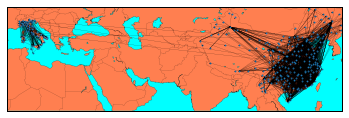

In [7]:
import networkx as nx

def create_network(airports, routes):
    
    # CREATING NETWORKS STRUCTURE: NODES
    import networkx as nx

    network = nx.MultiDiGraph()
    for airport in airports:
        if not airport.iata =='\\N':
            network.add_node(airport.iata)
        elif not airport.icao =='\\N':
            network.add_node(airport.icao)
        else: print('problem', airport.name)
    
    # CREATING NETWORKS STRUCTURE: EDGES
    for route in routes:
        if not route.source_iata == "" :
            source = route.source_iata
        elif not route.source_icao == "" :
            source = route.source_icao
        else : print('problem', route)
        if not route.dest_iata == "" :
            dest = route.dest_iata
        elif not route.dest_icao == "" :
            dest = route.dest_icao
        else : print('problem', route)
        network.add_edge(source, dest)
    
    return network

#CREATING SUBGRAPH WITH ONLY ITALIAN AND CHINESE AIRPORTS AND ROUTES
sairports = []
sroutes = []
for airport in airports:
    if airport.country == "Italy" or airport.country == "China" :
        sairports.append(airport)

for route in routes:
    if not route.source_iata == "\\N" and not route.dest_iata == "\\N" :
        if route.source_iata in [airport.iata for airport in sairports] and route.dest_iata in [airport.iata for airport in sairports]:
            sroutes.append(route)
    else:
        print('problem')

network = create_network(sairports, sroutes)

#MAP VISUALIZATION
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import networkx as nx
fig=plt.figure()
m = Basemap(llcrnrlon=3.,llcrnrlat=15.,urcrnrlon=130.,urcrnrlat=50.,\
            resolution='l',projection='mill')

m.drawcountries(linewidth = 0.1)
m.fillcontinents(color='coral', lake_color='aqua')
m.drawcoastlines(linewidth=0.15)
m.drawmapboundary(fill_color='aqua')

pos = {}
for airport in airports:
    if not airport.iata == "\\N":
        pos[airport.iata] = m(airport.long, airport.lat)
    else :
        pos[airport.icao] = m(airport.long, airport.lat)
        
nx.draw_networkx(network, pos, node_size=0.7, font_size=0.04, width=0.06, arrowsize=1, aplha=0.5)
plt.savefig("network.png", dpi=1500, format="PNG",)

## Ora provo a creare una classe che userò per fare le simulazioni: SIR o SIS.

In [3]:
import numpy as np

glob_bb = 0.2 # beta: global rate of infection per contact
glob_uu = 0.1 # mu  : global rate of recovery
chi = 0.0 # if 0.0 SIR, if uu SIS
dt = 0.2

class Node:
    """ Could be a city, a region, a country... 
        depending on the resolution of the 
        simulation """
    def __init__(self, name, init_pop, bb=glob_bb, uu=glob_uu):
        self.name = str(name)
        self.init_population = float(init_pop)
        self.sus = 1.0
        self.inf = 0. # inital infected
        self.bb = float(bb)
        self.uu = float(uu)
        self.neigs = [] # list of neighbours in the network
        self.history = np.ndarray(shape=(1,3))
        self.history[0,:] = self.sus, self.inf, 1.0 - self.sus - self.inf
    
    def add_neig(self,neig):
        ## should be another node of same class
        if not neig in self.neigs:
            self.neigs.append(neig)
    
    def infect(self, perc):
        infected = self.sus*perc
        self.inf += infected
        self.sus -= infected
        present = np.ndarray(shape=(1,3))
        present[0,:] = self.sus, self.inf, 1.0 - self.sus - self.inf
        self.history = np.concatenate((self.history, present))
    
    def step(self):
        # TODO How frequent should be called ? Once a day ?
        inff = self.inf
        self.inf += ( self.bb*self.inf*self.sus - self.uu*self.inf ) * dt
        self.sus += ( -self.bb*inff*self.sus + chi*inff ) * dt
        present = np.ndarray(shape=(1,3))
        present[0,:] = self.sus, self.inf, 1.0 - self.sus - self.inf
        self.history = np.concatenate((self.history, present))
    
    def evolve(self, steps):
        for i in range(steps-1):
            lombardia.step()

    def plot(self):
        import matplotlib.pyplot as plt
        plt.title(str(self.name))
        plt.xlabel("t []")
        plt.plot(self.history[:,0], label="S")
        plt.plot(self.history[:,1], label="I")
        plt.plot(self.history[:,2], label="R")
        plt.legend()
        plt.show()

In [4]:
lombardia = Node("Lombardia", 10e6)
lombardia.infect(0.02)
lombardia.evolve(500)

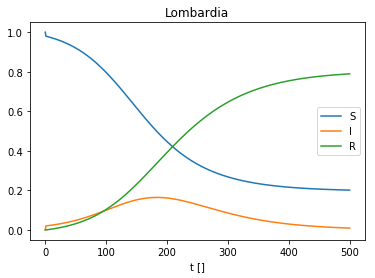

In [6]:
lombardia.plot()

# Importo flussi dal file

### importo file dei flussi in una lista "airports_new"

In [7]:
import csv

i = 0
airports_new = []
with open('./pdf_to_csv/passeggeri_voli_italiani_2017.csv') as file :
        reader = csv.reader(file, delimiter=',')
        for line in reader:
            #print(line)
            airports_new.append(line)
            i += 1
print(i)

167


### traduco i nomi delle città per mantenere i nomi del nostro database iniziale

In [8]:
translated_airports_new = []
for airport in airports_new:
    translated_airport = []
    for i in range(len(airports_new[0])):
        if 'Napoli' in airport[i]:
            translated_airport.append(airport[i].replace('Napoli','Naples'))
        elif 'Roma Fiumicino' in airport[i]:
            translated_airport.append(airport[i].replace('Roma Fiumicino','Rome'))
        elif 'Roma Ciampino' in airport[i]:
            translated_airport.append(airport[i].replace('Roma Ciampino','Rome'))
        elif 'Milano Linate' in airport[i]:
            translated_airport.append(airport[i].replace('Milano Linate','Milan'))
        elif 'Milano Malpensa' in airport[i]:
            translated_airport.append(airport[i].replace('Milano Malpensa','Milan'))
        elif 'Venezia' in airport[i]:
            translated_airport.append(airport[i].replace('Venezia','Venice'))
        elif 'Lamezia Terme' in airport[i]:
            translated_airport.append(airport[i].replace('Lamezia Terme','Lamezia'))
        elif 'Genova' in airport[i]:
            translated_airport.append(airport[i].replace('Genova','Genoa'))
        elif 'Firenze' in airport[i]:
            translated_airport.append(airport[i].replace('Firenze','Florence'))
        elif 'Trieste' in airport[i]:
            translated_airport.append(airport[i].replace('Trieste','Ronchi De Legionari'))
        else:
            translated_airport.append(airport[i])

        
    translated_airports_new.append(translated_airport)

del translated_airports_new[0]

### controllo che tutti gli aeroporti nel nuovo file siano già nel nostro database

In [9]:
i = 0
for line in translated_airports_new:
    if not line[0] in [airport.city for airport in airports] or not line[1] in [airport.city for airport in airports]:
        print(line)
        i += 1
if i == 0: print('OK!')

OK!


### aggiungo l'info sul flusso agli oggetti nella lista it_routes

In [10]:
it_routes = []
for route in routes:
    if route.dest_country == 'Italy' and route.source_country == 'Italy':
        it_routes.append(route)


for route in it_routes: route.flux = 0 # inizializzo a zero tutti i flussi
tan = translated_airports_new # per brevità
for link in tan:
    for route in it_routes:
        if link[0]==route.source_city and link[1]==route.dest_city :
            route.flux += int(link[2])

it_routes = sorted(it_routes, key=lambda x: -x.flux)
for route in it_routes:
    route.info()
    
it_airports = []
for airport in airports:
    if airport.country == 'Italy':
        it_airports.append(airport)

In [53]:
import folium
def create_map(center=[42,13]):
    return folium.Map(location=center, zoom_start=5)

def add_city(mappa,airport):
    folium.Circle(radius=5e3, location=[airport.lat, airport.long], popup=airport.info(),
                        icon=folium.Icon(color='lightblue')
                       ).add_to(mappa)

def add_link(mappa, route, airports):
    for airport in airports:
        if route.source_iata == airport.iata:
            source_lat = airport.lat
            source_long = airport.long
        elif route.source_icao == airport.icao:
            source_lat = airport.lat
            source_long = airport.long
        elif route.dest_iata == airport.iata:
            dest_lat = airport.lat
            dest_long = airport.long
        elif route.dest_icao == airport.icao:
            dest_lat = airport.lat
            dest_long = airport.long
        #else: print('Problem')
    folium.PolyLine(locations=[[source_lat, source_long], [dest_lat, dest_long]],
                    weight=1e-6*route.flux, color='black', popup=route.info()
                   ).add_to(mappa)
    
    
m = create_map()
for airport in it_airports:
    add_city(m, airport)

for route in it_routes:
    add_link(m, route, it_airports)
m